<a href="https://colab.research.google.com/github/ernestag777/Openmc4l/blob/main/Copy_of_Webinar_03_10_22_students_version_mod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creación de ambiente virtual

In [ ]:

def install_openmc():
  #
  # Clone source code from Github, make and install
  #

  import os

  if not os.path.isdir('/content'):
    print("Esta función instala OpenMC en una instancia de Google Colaboratory.")
    print("Para instalar localmente siga las instrucciones de la documentacion:")
    print("http://docs.openmc.org/en/stable/quickinstall.html")
    return

  %cd -q /content
  print("Obteniendo código fuente de Github...")
  !git  --no-pager clone https://github.com/openmc-dev/openmc.git &> /dev/null
  %cd -q openmc
  !git --no-pager checkout master &> /dev/null
  !mkdir build
  %cd -q build
  print("Running cmake...")
  !cmake ../ -DPYTHON_EXECUTABLE=/usr/bin/python3 -DCMAKE_INSTALL_PREFIX=/usr/local &> /dev/null
  print("Running make...")
  !make -j &> /dev/null
  print("Running make install...")
  !make install &> /dev/null
  %cd -q /content/openmc
  !pip install . &> /dev/null

  !apt update &> /dev/null
  !apt install python3-vtk7 imagemagick &> /dev/null

  %cd -q /content

def install_data_from_onedrive():

  import os

  if not os.path.isdir('/content'):
    print("Esta función instala los datos nucleares de OpenMC en una instancia de Google Colaboratory.")
    print("Para instalar localmente siga las instrucciones de la documentacion:")
    print("http://docs.openmc.org/en/stable/quickinstall.html")
    return


  print("descargando librería nuclear de la base de datos oficial")
  print("https://openmc.org/official-data-libraries/")
  %cd -q /content
  !wget -O endfb71.tar.xz "https://anl.box.com/shared/static/9igk353zpy8fn9ttvtrqgzvw1vtejoz6.xz" &> /dev/null
  !tar -xJf endfb71.tar.xz &> /dev/null


from time import time
t1 = time()
install_openmc()
install_data_from_onedrive()
t2 = time()
print("Se instaló OpenMC en {:.2f} minutos".format((t2-t1)/60.0))


Obteniendo código fuente de Github...
Running cmake...
Running make...
Running make install...
descargando librería nuclear de la base de datos oficial
https://openmc.org/official-data-libraries/
Se instaló OpenMC en 28.15 minutos


# Modelado de un Pin-Cell
En este módulo, se demuestran las características básicas de la API de Python para construir archivos de entrada y ejecutar OpenMC.

Materiales que se usan:
- UO<sub>2</sub> con 10 g/cm<sup>3</sup>
  - U235 al 0.02115 a/o
  - U238 al 0.86032 a/o
  - O16 al 0.11852 a/o
- Revestido de Zirconium con 6.6 g/cm<sup>3</sup>
  - Elemental Zr
- Water moderator con 1.0 g/cm<sup>3</sup>
  - H1 al 2.0 a/o
  - O16 al 1.0 a/o

Las dimensiones serán las siguientes:
- Radio exterior del combustible = 0,39 cm
- Radio interior del  revestimiento = 0,40 cm
- Radio exterior del revestimiento = 0,46 cm
- Paso del pasador de combustible = 1,26 cm




### El archivo `cross_sections.xml`

`cross_sections.xml` le dice a OpenMC dónde puede encontrar los cross section de nucleidos y tablas $S(\alpha,\beta)$. Tiene el mismo propósito que el archivo `xsdir` de MCNP y el archivo `xsdata` de Serpent. Como mencionamos, esto se puede establecer mediante la variable de entorno `OPENMC_CROSS_SECTIONS` o el atributo `Materials.cross_sections`.



In [ ]:
import openmc
import os
os.environ['OPENMC_CROSS_SECTIONS'] ='/content/endfb71_hdf5/cross_sections.xml'

## Paso 1: Definir los materiales

Los materiales en OpenMC se definen como un conjunto de nucleidos con fracciones atómicas/peso específicas. Para comenzar, crearemos un material creando una instancia de la clase 'Material'. En OpenMC, muchos objetos, incluidos los materiales, se identifican mediante una "identificación única" que es simplemente un número entero positivo. Estos ID se utilizan al exportar archivos XML que lee el solucionador. También aparecen en la salida y se pueden utilizar para la identificación. Dado que una ID de número entero no es muy útil por sí misma, también puede dar un nombre a un material.

La definición de materiales en openmc se realiza llamando a la función `Material()`:

In [ ]:
uo2 = openmc.Material(1, "uo2")
print(uo2)

Material
	ID             =	1
	Name           =	uo2
	Temperature    =	None
	Density        =	None [sum]
	S(a,b) Tables  
	Nuclides       



En el lado XML, se debe proporcionar una identificación. Sin embargo, en la API de Python, si no se proporciona una ID, se generará una automáticamente:

In [ ]:
mat = openmc.Material()
print(mat)

Material
	ID             =	2
	Name           =	
	Temperature    =	None
	Density        =	None [sum]
	S(a,b) Tables  
	Nuclides       



Vemos que automáticamente se asignó un ID de 2. Pasemos ahora a agregar nucleidos a nuestro material `uo2`. El objeto`Material` tiene un método `add_nuclide()` cuyo primer argumento es el nombre del nucleido y el segundo argumento es el átomo o fracción de peso.


In [ ]:
help(uo2.add_nuclide)


Help on method add_nuclide in module openmc.material:

add_nuclide(nuclide: str, percent: float, percent_type: str = 'ao') method of openmc.material.Material instance
    Add a nuclide to the material
    
    Parameters
    ----------
    nuclide : str
        Nuclide to add, e.g., 'Mo95'
    percent : float
        Atom or weight percent
    percent_type : {'ao', 'wo'}
        'ao' for atom percent and 'wo' for weight percent



Por defecto se asume fracción atómica

In [ ]:
# Ejemplo de como agregar nucleídos uo2
uo2.add_nuclide('U235', 0.02115)
uo2.add_nuclide('U238', 0.86032)
uo2.add_nuclide('O16', 0.11852)

Para asignar la densidad del materia se usa `set_density`.

In [ ]:
uo2.set_density('g/cm3', 10.0)

A veces se le puede dar una especificación de material donde todas las densidades de nucleidos están en unidades de átomo/b-cm. En este caso, solo desea que la densidad sea la suma de los constituyentes. En ese caso, simplemente puede ejecutar `mat.set_density('sum')`.

Ahora vamos a crear materiales para el revestimiento y el refrigerante. Tenga en cuenta el uso de `add_element()` para el circonio.


In [ ]:
#EJERCICIO: Con lo aprendido completa la creación los siguientes materiales

zirconium = openmc.Material(name="zirconium")
zirconium.add_element('Zr',1.0)
zirconium.set_density('g/cm3', 6.6)

water = openmc.Material(name="h2o")
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', 1.0)

El tratamiento default para la sección eficaz de scattering para neutrones térmicos es el de gas libre a la temperatura de la celda o material. En caso de que la biblioteca tenga secciones eficaces de scattering térmico, estas pueden especificarse en la definición del material utilizando el método .add_s_alpha_beta(). Tenga en cuenta el uso del nombre de estilo GND "c_H_in_H2O".

In [ ]:
water.add_s_alpha_beta('c_H_in_H2O')

Para crear realmente un archivo `materials.xml`, necesitamos instanciar una colección `Materials` y exportarla a XML.


In [ ]:
materials = openmc.Materials([uo2, zirconium, water])

Tenga en cuenta que `Materials` es en realidad una subclase de la `lista` integrada de Python, por lo que se puede usar métodos como `append()`, `insert()`, `pop()`, etc.

In [ ]:
materials = openmc.Materials()
materials.append(uo2)
materials += [zirconium, water]
isinstance(materials, list)

True

Finalmente, podemos crear el archivo XML con el método `export_to_xml()`. En un cuaderno de Jupyter, podemos ejecutar un comando de shell poniendo `!` delante de él, por lo que en este caso mostraremos el archivo `materials.xml` que creamos.

In [ ]:
materials.export_to_xml()
!cat materials.xml

<?xml version='1.0' encoding='utf-8'?>
<materials>
  <material depletable="true" id="1" name="uo2">
    <density units="g/cm3" value="10.0" />
    <nuclide ao="0.02115" name="U235" />
    <nuclide ao="0.86032" name="U238" />
    <nuclide ao="0.11852" name="O16" />
  </material>
  <material id="3" name="zirconium">
    <density units="g/cm3" value="6.6" />
    <nuclide ao="0.5145" name="Zr90" />
    <nuclide ao="0.1122" name="Zr91" />
    <nuclide ao="0.1715" name="Zr92" />
    <nuclide ao="0.1738" name="Zr94" />
    <nuclide ao="0.028" name="Zr96" />
  </material>
  <material id="4" name="h2o">
    <density units="g/cm3" value="1.0" />
    <nuclide ao="2.0" name="H1" />
    <nuclide ao="1.0" name="O16" />
    <sab name="c_H_in_H2O" />
  </material>
</materials>


## Definición de geometría

En este punto, tenemos tres materiales definidos, exportados a XML y listos para usar en nuestro modelo. Para terminar nuestro modelo, necesitamos definir la disposición geométrica de los materiales. OpenMC representa volúmenes físicos usando geometría sólida constructiva (CSG), también conocida como geometría combinatoria. El objeto que nos permite asignar un material a una región del espacio se llama 'Celda' (mismo concepto en MCNP, para aquellos familiarizados). Para definir una región que podamos asignar a una celda, primero debemos definir las superficies que limitan la región. Una *superficie* es un lugar geométrico de ceros de una función de coordenadas cartesianas $x$, $y$ y $z$, p.

- Un plano perpendicular al eje x: $x - x_0 = 0$
- Un cilindro paralelo al eje z: $(x - x_0)^2 + (y - y_0)^2 - R^2 = 0$
- Una esfera: $(x - x_0)^2 + (y - y_0)^2 + (z - z_0)^2 - R^2 = 0$

Entre esas tres clases de superficies (planos, cilindros, esferas), se puede construir una amplia variedad de modelos. También es posible definir conos y superficies generales de segundo orden.

Tenga en cuenta que definir una superficie no es suficiente para especificar un volumen: para definir un volumen real, se debe hacer referencia al semiespacio de una superficie. Un *semiespacio* de superficie es la región cuyos puntos satisfacen una desigualdad positiva o negativa de la ecuación de la superficie. Por ejemplo, para una esfera de radio uno centrada en el origen, la ecuación de superficie es $f(x,y,z) = x^2 + y^2 + z^2 - 1 = 0$. Así, decimos que el semiespacio negativo de la esfera, se define como el conjunto de puntos que satisfacen $f(x,y,z) < 0$, que se puede razonar es el interior de la esfera. Por el contrario, el semiespacio positivo de la esfera correspondería a todos los puntos fuera de la esfera.

Avancemos y creemos una esfera y confirmemos que lo que les hemos dicho es verdad.

In [ ]:
sphere = openmc.Sphere(r=1.0)



Tenga en cuenta que, de forma predeterminada, la esfera está centrada en el origen, por lo que no tuvimos que proporcionar los argumentos `x0`, `y0` o `z0`. Estrictamente hablando, también podríamos haber omitido `r` ya que por defecto es uno. Para obtener el medio espacio negativo o positivo, simplemente necesitamos aplicar los operadores unarios `-` o `+`, respectivamente.

(NOTA: Esos operadores unarios están definidos por métodos especiales: `__pos__` y `__neg__` en este caso).

In [ ]:
inside_sphere = -sphere
outside_sphere = +sphere

Ahora veamos si `inside_sphere` en realidad contiene puntos dentro de la esfera:

In [ ]:
print((0,0,0) in inside_sphere, (0,0,2) in inside_sphere)
print((0,0,0) in outside_sphere, (0,0,2) in outside_sphere)

True False
False True




¡Todo funciona como se esperaba! Ahora que sabemos cómo crear medios espacios, podemos crear volúmenes más complejos combinando medios espacios con operadores booleanos: `&` (intersección), `|` (unión) y `~` (complemento). Por ejemplo, digamos que queremos definir una región que es la parte superior de la esfera (todos los puntos dentro de la esfera que tienen $z > 0$.

In [ ]:
#EJERCICIO
z_plane = openmc.ZPlane(0)
northern_hemisphere = -sphere & +z_plane

Para muchas regiones, OpenMC puede determinar automáticamente un cuadro delimitador. Para obtener el cuadro delimitador, usamos la propiedad `bounding_box` de una región, que devuelve una tupla de las coordenadas cartesianas inferior izquierda y superior derecha para el cuadro delimitador:

In [ ]:
northern_hemisphere.bounding_box

(array([-1., -1.,  0.]), array([1., 1., 1.]))

Los volumenes (semiespacios) serán las regiones de las cell

In [ ]:
cell = openmc.Cell()
cell.region = northern_hemisphere

# o...
cell = openmc.Cell(region=northern_hemisphere)


Por defecto, la celda no se rellena con ningún material (vacío). Para asignar un material, establecemos la propiedad `fill` de una `Cell`.




In [ ]:
cell.fill = water

### Universes and in-line plotting

Una colección de celdas se conoce como universo y se puede usar como una unidad repetible al crear un modelo. Aunque todavía no lo necesitamos, el beneficio de crear un universo es que podemos visualizar nuestra geometría mientras la creamos.

In [ ]:
universe = openmc.Universe()
universe.add_cell(cell)

# this also works
universe = openmc.Universe(cells=[cell])

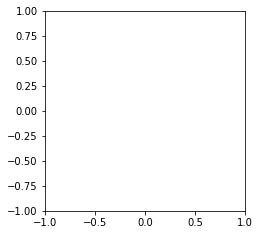

In [ ]:
universe.plot(width=(2.0, 2.0))

Por defecto, el gráfico aparecerá en el plano $x$-$y$. Podemos cambiar eso con el argumento `basis`.

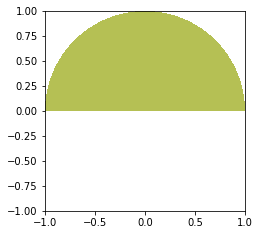

In [ ]:
universe.plot(width=(2.0, 2.0), basis='xz')

Si nos gusta especialmente, por ejemplo, el fucsia, podemos indicarle al método `plot()` que haga que nuestra celda tenga ese color.

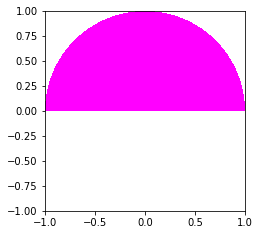

In [ ]:
universe.plot(width=(2.0, 2.0), basis='xz',
              colors={cell: 'fuchsia'})



### Geometría de Pin cell

Ahora tenemos suficiente conocimiento para crear nuestro pin-cell. Necesitamos tres superficies para definir el combustible y el revestimiento:

1. La superficie exterior del combustible: un cilindro paralelo al eje z
2. La superficie interna del revestimiento -- igual que arriba
3. La superficie exterior del revestimiento -- igual que arriba

Estas tres superficies serán todas instancias de `openmc.ZCylinder`, cada una con un radio diferente según la especificación.

In [ ]:
fuel_outer_radius = openmc.ZCylinder(r=0.39)
clad_inner_radius = openmc.ZCylinder(r=0.40)
clad_outer_radius = openmc.ZCylinder(r=0.46)

Con las superficies creadas, ahora podemos aprovechar los operadores incorporados en las superficies para crear regiones para el combustible, el espacio y el revestimiento:

In [ ]:
#EJERCICIO: completar las regiones según lo aprendido anteriormente
fuel_region = -fuel_outer_radius
gap_region = +fuel_outer_radius & -clad_inner_radius
clad_region = +clad_inner_radius & -clad_outer_radius

Ahora podemos crear celdas correspondientes que asignan materiales a estas regiones. Al igual que con los materiales, las celdas tienen ID únicos que se asignan de forma manual o automática. Tenga en cuenta que la celda de separación no tiene ningún material asignado (está anulada de forma predeterminada).

In [ ]:
fuel = openmc.Cell(name='fuel')
fuel.fill = uo2
fuel.region = fuel_region

#EJERCICIO: Cree las celdas faltantes
gap = openmc.Cell()
gap.region = gap_region

clad = openmc.Cell()
clad.fill = zirconium
clad.region = clad_region

Finalmente, debemos manejar el refrigerante fuera de nuestro  combustible. Para hacer esto, creamos planos x e y que delimitan la geometría.

A diferencia de otros códigos Monte Carlo (como MCNP), en los que las condiciones de contorno se establecen en forma volumétrica, las condicionces de contorno en OpenMC se establecen sobre superficies con el parámetro `boundary_type=`. El valor por default para este parámetro es `transmission`, que permite que las partículas atraviesen la superficie sin ningún impedimento. Si esta parámetro se coloca en `vacuum`, OpenMC terminará la historia de las partículas que atraviesan la superficie, generando una condición de contorno de corriente entrante nula (esto es, vacío). Si se coloca el parámetro `reflective` la superficie reflejará las partículas que lleguen a ella, generando una condición de contorno reflejada.

In [ ]:
pitch = 1.26
left = openmc.XPlane(-pitch/2, boundary_type='reflective')
right = openmc.XPlane(pitch/2, boundary_type='reflective')
bottom = openmc.YPlane(-pitch/2, boundary_type='reflective')
top = openmc.YPlane(pitch/2, boundary_type='reflective')

La región del agua será todo lo que esté fuera del radio exterior del revestimiento y dentro de la caja formada como la intersección de cuatro semiespacios.

In [ ]:
water_region = +left & -right & +bottom & -top & +clad_outer_radius

moderator = openmc.Cell(name='moderator')
moderator.fill = water
moderator.region = water_region

OpenMC también incluye una función de fábrica que genera un prisma rectangular que podría habernos hecho la vida más fácil.

In [ ]:
box = openmc.rectangular_prism(width=pitch, height=pitch,
                               boundary_type='reflective')
type(box)

openmc.region.Intersection

El objeto que se devolvió NO es una superficie. En realidad, es la intersección de cuatro semiespacios de superficie, tal como lo creamos manualmente antes. Por lo tanto, no necesitamos aplicar el operador unario (`-box`). En su lugar, podemos combinarlo directamente con `+clad_or`.

In [ ]:
water_region = box & +clad_outer_radius

El paso final es asignar las celdas que creamos a un universo y decirle a OpenMC que este universo es el universo "raíz" en nuestra geometría. La `Geometría` es el objeto final que realmente se exporta a XML.

<?xml version='1.0' encoding='utf-8'?>
<geometry>
  <cell id="3" material="1" name="fuel" region="-3" universe="3" />
  <cell id="4" material="void" region="3 -4" universe="3" />
  <cell id="5" material="3" region="4 -5" universe="3" />
  <cell id="6" material="4" name="moderator" region="6 -7 8 -9 5" universe="3" />
  <surface coeffs="0.0 0.0 0.39" id="3" type="z-cylinder" />
  <surface coeffs="0.0 0.0 0.4" id="4" type="z-cylinder" />
  <surface coeffs="0.0 0.0 0.46" id="5" type="z-cylinder" />
  <surface boundary="reflective" coeffs="-0.63" id="6" type="x-plane" />
  <surface boundary="reflective" coeffs="0.63" id="7" type="x-plane" />
  <surface boundary="reflective" coeffs="-0.63" id="8" type="y-plane" />
  <surface boundary="reflective" coeffs="0.63" id="9" type="y-plane" />
</geometry>


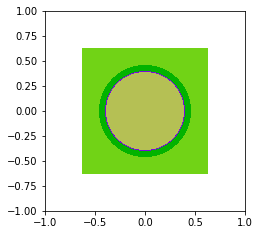

In [ ]:
root_universe = openmc.Universe(cells=(fuel, gap, clad, moderator))
root_universe.plot(width=(2.0, 2.0), basis='xy')
geometry = openmc.Geometry(root_universe)
geometry.export_to_xml()
!cat geometry.xml


## Parámetros de ejecución y fuente

La API de Python tiene un módulo `openmc.stats` con varias distribuciones de probabilidad univariadas y multivariadas. Podemos usar estas distribuciones para crear una fuente de inicio usando el objeto `openmc.Source`. Uno puede especificar independientemente la distribución espacial (`espacio`), la distribución angular (`ángulo`), la distribución de energía (`energía`) y la distribución de tiempo (`tiempo`). Para este ejemplo, solo especificaremos la distribución espacial como un solo punto.

In [ ]:
# Create a point source
point = openmc.stats.Point((0, 0, 0))
source = openmc.Source(space=point)

Ahora vamos a crear un objeto de configuración y darle la fuente que creamos junto con la especificación de cuántos lotes y partículas queremos ejecutar.

In [ ]:
settings = openmc.Settings()
settings.source = source
settings.batches = 100
settings.inactive = 10
settings.particles = 1000

#EJERCIO cambiar datos y hacer calculos de partículas simuladas

In [ ]:
settings.export_to_xml()
!cat settings.xml

<?xml version='1.0' encoding='utf-8'?>
<settings>
  <run_mode>eigenvalue</run_mode>
  <particles>1000</particles>
  <batches>100</batches>
  <inactive>10</inactive>
  <source strength="1.0">
    <space type="point">
      <parameters>0 0 0</parameters>
    </space>
  </source>
</settings>


In [ ]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

# Para hacer la vida más fácil

## Clase `Model`

Hasta ahora, hemos visto que para crear y simular un modelo, teníamos que crear una instancia de `Geometry`, `Materials` y `Settings` y llamar al método `export_to_xml` en cada uno de ellos. OpenMC también proporciona una clase `Model` que agrega estas clases y proporciona un único método `export_to_xml` que exportará todos los archivos.

In [ ]:
# Combine the three classes into a single model
model = openmc.Model()
model.geometry = geometry
model.materials = materials
model.settings = settings

# Export all at once
model.export_to_xml()

La clase `Model` también tiene un método `run` que exportará archivos XML *y* ejecutará una simulación, devolviendo el nombre del último archivo de punto de estado que se escribió:

In [ ]:
model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

PosixPath('/content/statepoint.100.h5')

# OpenMC Tallies

Un conteo (tallie) acumula información estadística durante la simulación sobre partículas cuando entran en regiones del espacio de fase especificado. Los límites de estas regiones se establecen mediante filtros.

Cualquier Tallie en OpenMC se puede describir con la siguiente forma:

$$
  X = \underbrace{\int d\mathbf{r} \int d\mathbf{\Omega} \int
     dE}_{\text{filtros}} \underbrace{f(\mathbf{r}, \mathbf{\Omega},
     E)}_{\text{scores}} \psi (\mathbf{r}, \mathbf{\Omega}, E)
$$

donde los filtros establecen los límites de las integrales y la función de puntuación (score) se convoluciona con información de partículas (por ejemplo, tipo de reacción, material actual, etc.).

Los filtros son utilizados para determinar la región del espacio de fase donde se contarán los eventos del tally. Existen muchos filtros (la lista completa [está en el manual](https://openmc.readthedocs.io/en/stable/pythonapi/base.html#pythonapi-tallies)). Los principales son:

* `CellFilter()`: cuenta los eventos que ocurren en una determinada celda.
* `EnergyFilter()`: cuenta los eventos en un determinado rango de energía.
* `MeshFilter()`: cuenta eventos que ocurren en una determinada grill cartesiano.

El score define qué se va a contar en cada evento. Algunos de los más importantes son:
* `flux`: flujo escalar.
* `current`: corriente en una superficie o en una malla.
* `absorption`: ritmo de absorciones (flujo pesado por la sección eficaz de absorción).
* `elastic`: ritmo de scattering.
* `fission`: ritmo de fisiones.
* `total`: ritmo de reacción total.
* `(n,gamma)`: ritmo de captura radiativa

<div class="alert alert-block alert-info">
Lista oficial de scores<a href=https://docs.openmc.org/en/stable/usersguide/tallies.html#scores >here</a>.
</div>

## Pincell Model
 La siguiente función genera un modelo pincell PWR 2-D con condiciones de contorno reflectantes en los planos X-Y. Esta función proporciona un objeto `openmc.Model`, que une materiales, geometría, conteos y configuraciones en un solo objeto de Python con una descripción completa del problema.

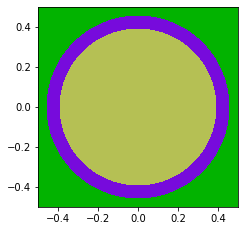

In [ ]:
pincell_model = openmc.examples.pwr_pin_cell()
pincell_model.geometry.root_universe.plot()

Para tener una mejor idea de cómo se ve este modelo, comenzaremos generando un gráfico y examinando los materiales utilizados.

In [ ]:
pincell_model.geometry.get_all_materials()

OrderedDict([(5, Material
              	ID             =	5
              	Name           =	UO2 (2.4%)
              	Temperature    =	None
              	Density        =	10.29769 [g/cm3]
              	S(a,b) Tables  
              	Nuclides       
              	U234           =	4.4843e-06   [ao]
              	U235           =	0.00055815   [ao]
              	U238           =	0.022408     [ao]
              	O16            =	0.045829     [ao]), (6, Material
              	ID             =	6
              	Name           =	Zircaloy
              	Temperature    =	None
              	Density        =	6.55 [g/cm3]
              	S(a,b) Tables  
              	Nuclides       
              	Zr90           =	0.021827     [ao]
              	Zr91           =	0.00476      [ao]
              	Zr92           =	0.0072758    [ao]
              	Zr94           =	0.0073734    [ao]
              	Zr96           =	0.0011879    [ao]), (7, Material
              	ID             =	7
              	N

Observar que tallies hay hasta ahora

In [ ]:
pincell_model.tallies

[]

En este ejercicio agregaremos registros para realizar algunas tareas diferentes:


   **1. Determinar la energía y el calor producidos por fisión** \
   **2. Trazar el espectro de flujo del pincell** \
   **3. Trazar los tipos de reacción según el material** (Por cuestiones de tiempo sólo se realizará este ejercico, sin embargo se recomienda estudiar los otros dos de manera individual)
  
Para hacer esto, usaremos una variedad de filtros diferentes aplicados a diferentes conteos.

Primero, para determinar la energía recuperable producida por fisión, crearemos un recuento sin filtros para recopilar información sobre la tasa de reacción de fisión ("`fisión`") y la energía de fisión recuperable ("`kappa-fission`"). Debido a que queremos que esta información se registre en todo el modelo, un recuento "global", no es necesario aplicar filtros.



## Tarea 1: Energía liberada por fisión

In [ ]:
fission_tally = openmc.Tally()
fission_tally.scores = ['fission', 'kappa-fission']
print(fission_tally)

Similar al objeto `openmc.Materials`, el objeto `openmc.Tallies` es una subclase de la `lista` integrada de Python y se utiliza para recopilar registros para aplicarlos al modelo.

In [ ]:
pincell_model.tallies = openmc.Tallies([fission_tally])


Después de ajustar la configuración predeterminada para la cantidad de partículas y lotes en el modelo, lo ejecutaremos y examinaremos los datos.

In [ ]:
pincell_model.settings.batches = 50
pincell_model.settings.inactive = 10
pincell_model.settings.particles = 10000
statepoint = pincell_model.run()

Si enumeramos nuestro directorio actual, vemos que se han creado varios archivos nuevos como resultado de esta ejecución: `summary.h5`, `tallies.out` y `statepoint.50.h5`. El archivo de resumen contiene información sobre la configuración de la simulación (geometría, materiales, mallas, etc.) en formato HDF5. El archivo `tallies.out` contiene una salida de texto de todas las cuentas especificadas por el usuario para la simulación.

In [ ]:
!cat tallies.out

El archivo statepoint contiene información sobre los resultados de la simulación, incluidas las especificaciones y los datos de conteo. La ubicación de este archivo statepoint nos la proporcionó el comando pincell_model.run().

In [ ]:
!ls
print(f'Statepoint: {statepoint}')

Para extraer información del archivo statepoint crearemos un objeto `openmc.StatePoint`. La función `statepoint.get_tally` buscará recuentos por puntajes, filtros, nucleidos, identificadores y devolverá la coincidencia más cercana. También se pueden especificar coincidencias exactas.

In [ ]:
with openmc.StatePoint('statepoint.50.h5') as sp:
    tally_by_scores = sp.get_tally(scores=['fission', 'kappa-fission'])
    tally_by_id = sp.get_tally(id=fission_tally.id)

Si mostramos los objetos de conteo devueltos, vemos que de hecho coinciden con la especificación de conteo que generamos anteriormente.

In [ ]:
print(tally_by_scores)
print(tally_by_id)
# shorten variable name f
tally = tally_by_id

Para calcular la energía liberada por evento de fisión, simplemente podemos tomar la energía contabilizada liberada por fisión y dividirla por la tasa de fisión.

In [ ]:
#Cuando se usa get_values te da la media, seria lo mismo que poner .mean
fission_rate = tally.get_values(scores=['fission']).flatten()[0]
kappa_fission = tally.get_values(scores=['kappa-fission']).flatten()[0]
ev_per_fission = kappa_fission / fission_rate
mev_per_fission = ev_per_fission * 1e-6
print(fission_rate)
print(f'MeV per fission: {mev_per_fission:.2f}')

Para un reactor de agua con U235 como único isótopo en fisión, esto es lo que cabría esperar: ¡~193,4 MeV!

  Como ocurre con la mayoría de los valores que salen de un código MC, estos valores son por partícula de origen. En este caso, estas unidades se anulan, pero este no será el caso en nuestro siguiente ejemplo.

## Tarea 2: GRaficar el espesctro de flujo


Para realizar esta tarea, estaremos aplicando un conteo con un filtro de energía. El módulo de datos de OpenMC contiene diferentes estructuras de grupos. Para este problema usaremos la estructura de grupos CASMO-70. Se puede crear fácilmente un filtro de energía a partir de una estructura de grupo predefinida en OpenMC de la siguiente manera:

In [ ]:
#https://docs.openmc.org/en/latest/pythonapi/mgxs.html
energy_filter = openmc.EnergyFilter(openmc.mgxs.GROUP_STRUCTURES['CASMO-70'])
len(energy_filter.bins)

70

In [ ]:
#Ejercicio
spectrum_tally = openmc.Tally()
spectrum_tally.filters = [energy_filter]
spectrum_tally.scores = ['flux']
print(spectrum_tally)

In [ ]:
pincell_model.tallies = [spectrum_tally]
statepoint = pincell_model.run()

In [ ]:
#Ejercicio
with openmc.StatePoint('statepoint.50.h5') as sp:
    tally = sp.get_tally(id=spectrum_tally.id)
    #las dos que siguen son ej opcionales
    sp.get_tally(scores=['flux'])
    sp.get_tally(filters=spectrum_tally.filters)

In [ ]:
spectrum = tally.mean
print(spectrum.shape)
print(spectrum)

In [ ]:
plt.figure(figsize=(16, 9))
#unique es e numpy, se excluye la ultima entrada
plt.step(np.unique(energy_filter.bins)[:-1], spectrum.flatten())
plt.xscale('log')
plt.rcParams['text.usetex'] = False
plt.xlabel(r'Energy (eV)')
plt.ylabel(r'Flux ($\frac{particle-cm}{source-particle}$)')
plt.show()

## Normalizar

Tenga en cuenta que las unidades de flujo en el gráfico anterior están en $\frac{particle-cm}{source-particle}$. Como es el caso con muchos valores contados por los códigos de Monte Carlo, el valor del flujo no tiene en cuenta el volumen y es en términos de la cantidad de partículas fuente emitidas. Para generar este mismo gráfico en términos de unidades de flujo absolutas ($\frac{particle}{cm^{2}-s}$) necesitaremos normalizar esta cuenta de la siguiente manera:

   - el volumen de la región que cubre el tallie
   - el número de partículas fuente emitidas

En este caso, el volumen de la región es el volumen de todo el pincell. Debido a que estamos trabajando con un modelo 2-D, obtendremos unidades que nos dan el flujo por unidad de longitud del pincell en la dirección axial. Para simplificar, supondremos que nuestro pincell tiene 1 cm de altura para hacer la vida más fácil. El objeto de geometría de OpenMC permite el cálculo de un cuadro delimitador para geometrías como esta que ayudará a que esto sea más sencillo.

In [ ]:
# get bounding box
lower_left, upper_right = pincell_model.geometry.bounding_box
print(lower_left, upper_right)
lower_left[-1] = 0.0
upper_right[-1] = 1.0
# compute volume
volume = np.prod(upper_right - lower_left)
print(volume)

Sin embargo, determinar el número de partículas fuente por segundo es más complicado. Esto significa calcular el número de neutrones de fisión generados por segundo en el modelo. Para obtener este valor, necesitaremos la siguiente información:

   1. la potencia total producida en la región de conteo (conocida a priori, usaremos )
   2. el calor producido por la energía de fisión
   3. la tasa de fisión
   4. el número medio de neutrones producidos por fisión
  
  Para obtener esta información, necesitaremos construir otro Tally para obtener información adicional de la simulación.

In [ ]:
pincell_power = 60.0e3 / 300 # in Watts
source_tally = openmc.Tally()
source_tally.scores = ['heating-local', 'nu-fission']
pincell_model.tallies = [source_tally]
pincell_model.export_to_xml()

In [ ]:
sp_file = pincell_model.run()

In [ ]:
with openmc.StatePoint(sp_file) as sp:
    source_tally_out = sp.get_tally(id=source_tally.id)
    heating = source_tally_out.get_values(scores=['heating-local']).flatten()[0]
    nu_fission = source_tally_out.get_values(scores=['nu-fission']).flatten()[0]

Así serí la combinación de Tallies en este caso:


$$ \text{neutron source} [\frac{n}{s}] = \text{power} [\frac{J}{s}] \times \frac{1}{1.6\times 10^{-19}} [\frac{eV}{J}] \times \frac{1}{\text{heat per fission} [\frac{eV}{fission}]} \times \text{neutrons per fission} [\frac{n}{fission}]$$

In [ ]:
heat_per_fission = heating / fission_rate
J_to_eV = 1 / 1.6e-19
neutron_source = pincell_power * J_to_eV * (1 / heat_per_fission) * nu_fission
print(f'Neutron source: {neutron_source:.2e} n/s')

In [ ]:
normalized_spectrum = neutron_source * spectrum.flatten() / volume

In [ ]:
plt.figure(figsize=(16, 9))
plt.step(np.unique(energy_filter.bins)[:-1], normalized_spectrum)
plt.xscale('log')
#plt.rcParams['text.usetex'] = False
plt.xlabel(r'Energy (eV)')
plt.ylabel(r'Flux ($\frac{particle}{cm^{-2} s}$)')
plt.show()

In [ ]:
plt.figure(figsize=(16, 9))
#esa diferencia da la resta entre los valores asi el resultado no se ve afectado
yu=np.diff(np.unique(energy_filter.bins))
plt.step(np.unique(energy_filter.bins)[:-1], normalized_spectrum/yu)
plt.xscale('log')
#plt.rcParams['text.usetex'] = False
plt.xlabel(r'Energy (eV)')
plt.ylabel(r'Flux ($\frac{particle}{cm^{-2} s}$)')
plt.show()

## Tarea 3: Reacción según el material

Observar los diferentes tipos de reacción por material

In [ ]:
material_filter = openmc.MaterialFilter(pincell_model.materials)

In [ ]:
material_tally = openmc.Tally()
material_tally.filters = [material_filter]
material_tally.scores = ['absorption', 'scatter', 'fission']

In [ ]:
pincell_model.tallies = [material_tally]

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

PosixPath('/content/statepoint.10.h5')

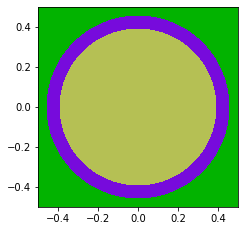

In [ ]:
pincell_model.geometry.root_universe.plot()
pincell_model.run()

Ahora recopilaremos información del archivo statepoint sobre cada puntaje que aplicamos al conteo. Con múltiples puntajes y materiales, usaremos un marco de datos de Pandas para ver los resultados de una manera más coherente.

In [ ]:
with openmc.StatePoint('statepoint.10.h5') as sp:
    tally = list(sp.tallies.values())[0]
    absorption = tally.get_values(scores=['absorption']).flatten()
    scatter = tally.get_values(scores=['scatter']).flatten()
    fission = tally.get_values(scores=['fission']).flatten()
    df = tally.get_pandas_dataframe()

Cada score tiene tres valores, uno para cada material del modelo.

In [ ]:
df

,material,nuclide,score,mean,std. dev.
0,5,total,absorption,0.858384,0.042483
1,5,total,scatter,5.454460,0.146132
2,5,total,fission,0.482122,0.022348
3,6,total,absorption,0.011401,0.000507
4,6,total,scatter,1.543061,0.035501
5,6,total,fission,0.000000,0.000000
6,7,total,absorption,0.156630,0.009135
7,7,total,scatter,23.766952,0.556440
8,7,total,fission,0.000000,0.000000


Primero, agregaremos una nueva columna al marco de datos con resultados normalizados.

In [ ]:
#la variable neutron source fue calculada previamente en la sección de normalizació de Tallies, para facilitar la ejecución de este ejercicio se define en esta celda como una constante
neutron_source = 7.28e+12
df['normalized-mean'] = neutron_source * df['mean']

Agregaremos una nueva entrada en el marco de datos para nuestros nombres de materiales para facilitar el trazado.

In [ ]:
# get all materials from the geometry
materials = pincell_model.geometry.get_all_materials()
# set names based on matching material IDs
for mat_id, material in materials.items():
    df.loc[df['material'] == mat_id, 'mat_name'] = material.name
df

,material,nuclide,score,mean,std. dev.,normalized-mean,mat_name
0,5,total,absorption,0.858384,0.042483,6.249037e+12,UO2 (2.4%)
1,5,total,scatter,5.454460,0.146132,3.970847e+13,UO2 (2.4%)
2,5,total,fission,0.482122,0.022348,3.509847e+12,UO2 (2.4%)
3,6,total,absorption,0.011401,0.000507,8.299820e+10,Zircaloy
4,6,total,scatter,1.543061,0.035501,1.123349e+13,Zircaloy
5,6,total,fission,0.000000,0.000000,0.000000e+00,Zircaloy
6,7,total,absorption,0.156630,0.009135,1.140264e+12,Hot borated water
7,7,total,scatter,23.766952,0.556440,1.730234e+14,Hot borated water
8,7,total,fission,0.000000,0.000000,0.000000e+00,Hot borated water


In [ ]:
fission_df = df[df['score'] == 'fission']
fission_df

,material,nuclide,score,mean,std. dev.,normalized-mean,mat_name
2,5,total,fission,0.482122,0.022348,3.509847e+12,UO2 (2.4%)
5,6,total,fission,0.000000,0.000000,0.000000e+00,Zircaloy
8,7,total,fission,0.000000,0.000000,0.000000e+00,Hot borated water


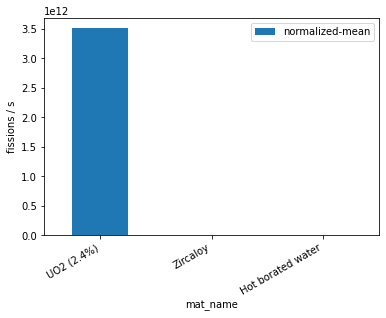

In [ ]:
fission_df.plot('mat_name', 'normalized-mean', kind='bar', ylabel='fissions / s')
from matplotlib import pyplot as plt
_ = plt.xticks(rotation=30, ha='right')

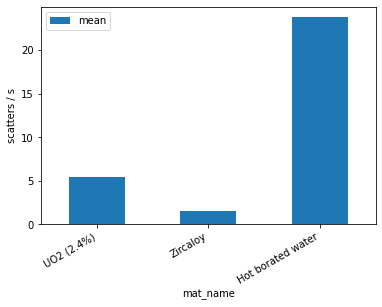

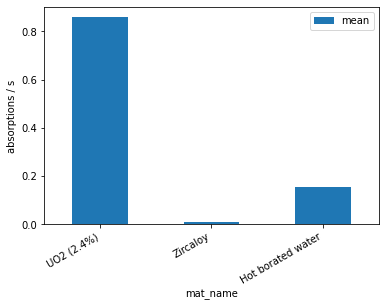

In [ ]:
scatter_df = df[df['score'] == 'scatter']
scatter_df.plot('mat_name', 'mean', kind='bar', ylabel='scatters / s')
_ = plt.xticks(rotation=30, ha='right')

absorption_df = df[df['score'] == 'absorption']
absorption_df.plot('mat_name', 'mean', kind='bar', ylabel='absorptions / s')
_ = plt.xticks(rotation=30, ha='right')

# Ejercicio Propuesto

**Obejtivo:**
Crear un programa que mida la dosis de radiacion según la distancia a una fuente puntal de Co60 blindado por un cilindro de acero.

Se propone en un ejercicio en 3 partes.

***Parte 1:***

Crear una geometria con las siguientes caracteristicas:

*   Fuente  de cobalto
*   Un cilindro de acero con diametro externo 72 cm, grosor de 1.5 cm y altura de 200cm
*   cree las esferas que rodean al cilindro con diferentes radios (estas son las superficies en las cuales se medira la dosis)
*   Recuerde delimitar el universo

*Nota:* Tome este códico como ayuda para la creación de las esferas dado que es repetitivo

1.

                s_2 = openmc.Sphere(r=225)
                s_3 = openmc.Sphere(r=250)
                s_4 = openmc.Sphere(r=275)
                s_5 = openmc.Sphere(r=300)
                s_6 = openmc.Sphere(r=325)
                s_7 = openmc.Sphere(r=350)
                s_8 = openmc.Sphere(r=375)
                s_9 = openmc.Sphere(r=400)

2.

                s_3_region = +s_2 & -s_3
                s_3_cell = openmc.Cell(region= s_3_region)
                s_4_region = +s_3 & -s_4
                s_4_cell = openmc.Cell(region= s_4_region)
                s_5_region = +s_4 & -s_5
                s_5_cell = openmc.Cell(region= s_5_region)
                s_6_region = +s_5 & -s_6
                s_6_cell = openmc.Cell(region= s_6_region)
                s_7_region = +s_6 & -s_7
                s_7_cell = openmc.Cell(region= s_7_region)
                s_8_region = +s_7 & -s_8
                s_8_cell = openmc.Cell(region= s_8_region)
                s_9_region = +s_8 & -s_9
                s_9_cell = openmc.Cell(region= s_9_region)

***Parte 2:***
Cree los tally que permitan medir la dosis en cada superficie esferica.

*Nota:* La "receta" para calcular dosis es:
1. Filtros de energía y coeficientes de dosis

2. Score de corriente

3. "Normalización de las unidades"
  *   Dividir por el área
  *   Dividir por el número de partículas.

4. Factores de origen.
tasa de emisión
decae por segundo

***Parte 3:*** Graficar tanto la geometría como dosis vs distancia.




In [ ]:
acero=openmc.Material()
acero.add_element('Fe', 0.98, percent_type='wo')
acero.add_element('C', 0.02, percent_type='wo')
acero.set_density('g/cm3', 7.75)

mats = openmc.Materials([acero])

In [ ]:
altura = 200
radio_exterior = 36
grosor = 1.5

cilindro_exterior= openmc.ZCylinder(r=radio_exterior)
cilindro_interior= openmc.ZCylinder(r=radio_exterior-grosor)

tapa_superior_exterior = openmc.ZPlane(z0=(altura*0.5)+grosor)
tapa_superior_interior = openmc.ZPlane(z0=(altura*0.5))

tapa_inferior_exterior = openmc.ZPlane(z0=(-altura*0.5)-grosor )
tapa_inferior_interior = openmc.ZPlane(z0= (-altura*0.5))

In [ ]:
cilindro_region = -cilindro_exterior & +cilindro_interior & -tapa_superior_interior & +tapa_inferior_interior
cilindro_cell = openmc.Cell(region= cilindro_region)
cilindro_cell.fill = acero

tapa_superior_region = -tapa_superior_exterior & +tapa_superior_interior & -cilindro_exterior
tapa_superior_cell = openmc.Cell(region=tapa_superior_region, fill= acero)

tapa_inferior_region = +tapa_inferior_exterior & -tapa_inferior_interior & -cilindro_exterior
tapa_inferior_cell = openmc.Cell(region = tapa_inferior_region, fill= acero)

void_region= -cilindro_interior & -tapa_superior_interior & +tapa_inferior_interior
void_cell = openmc.Cell(region = void_region)




In [ ]:
#Crear las espferas donde se medirá la dosis

s_1 = openmc.Sphere(r=200)
s_2 = openmc.Sphere(r=225)
s_3 = openmc.Sphere(r=250)
s_4 = openmc.Sphere(r=275)
s_5 = openmc.Sphere(r=300)
s_6 = openmc.Sphere(r=325)
s_7 = openmc.Sphere(r=350)
s_8 = openmc.Sphere(r=375)
s_9 = openmc.Sphere(r=400)

s_limite = openmc.Sphere(r=401, boundary_type='vacuum')

s_1_region = -s_1 & ~cilindro_region & ~tapa_superior_region & ~tapa_inferior_region & ~void_region
s_1_cell = openmc.Cell(region = s_1_region)

s_2_region = -s_2 & +s_1
s_2_cell = openmc.Cell(region=s_2_region)

s_3_region = +s_2 & -s_3
s_3_cell = openmc.Cell(region= s_3_region)
s_4_region = +s_3 & -s_4
s_4_cell = openmc.Cell(region= s_4_region)
s_5_region = +s_4 & -s_5
s_5_cell = openmc.Cell(region= s_5_region)
s_6_region = +s_5 & -s_6
s_6_cell = openmc.Cell(region= s_6_region)
s_7_region = +s_6 & -s_7
s_7_cell = openmc.Cell(region= s_7_region)
s_8_region = +s_7 & -s_8
s_8_cell = openmc.Cell(region= s_8_region)
s_9_region = +s_8 & -s_9
s_9_cell = openmc.Cell(region= s_9_region)

s_limite_region = +s_9 & -s_limite
s_limite_cell = openmc.Cell(region=s_limite_region)

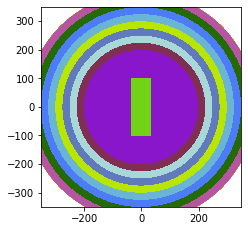

In [ ]:
universe = openmc.Universe(cells=[
    void_cell, cilindro_cell, tapa_superior_cell,
    tapa_inferior_cell, s_1_cell, s_2_cell,
    s_3_cell, s_4_cell,
    s_5_cell, s_6_cell, s_7_cell, s_8_cell, s_9_cell, s_limite_cell])

geom = openmc.Geometry(universe)

plt.show(universe.plot(width=(700,700), basis = 'xz'))


In [ ]:
sett = openmc.Settings()
sett.batches =10
sett.inactive = 0
sett.particles = 500
sett.run_mode= 'fixed source'

source = openmc.Source()
source.space = openmc.stats.Point((0,0,0,))
source.angle = openmc.stats.Isotropic()
source.energy = openmc.stats.Discrete([1.0e6],[1.0])
source.particle = 'photon'

sett.source = source


In [ ]:
energy_bins, dose_coeffs = openmc.data.dose_coefficients( particle= 'photon', geometry = 'AP')

energy_function_filter = openmc.EnergyFunctionFilter(energy_bins, dose_coeffs)

photon_particle_filter = openmc.ParticleFilter(['photon'])

surface_to_tally=[s_1, s_2, s_3, s_4, s_5, s_6, s_7, s_8, s_9]

n=1
tallies= openmc.Tallies()
for surface in surface_to_tally:
  surface_filter = openmc.SurfaceFilter(surface)
  dose_tally = openmc.Tally(name="dosis"+str(n))
  dose_tally.scores = ['current']
  dose_tally.filters = [surface_filter, photon_particle_filter, energy_function_filter ]
  tallies.append(dose_tally)
  n = n+1



In [ ]:
model = openmc.model.Model(geom,mats, sett, tallies)

sp_filename = model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [ ]:
import math

sp = openmc.StatePoint(sp_filename)

n=1
distances=[]
dose_rate_in_pSv=[]
for surface in surface_to_tally:
  tally = sp.get_tally(name="dosis"+ str(n))
  df = tally.get_pandas_dataframe()
  tally_result = df['mean'].sum()
  tally_std_dev = df ['std. dev.'].sum()

  #pSv*cm2
  dose_in_pSv = tally_result / (4* math.pi * math.pow(surface.r, 2))

  distances.append(surface.r)

  source_activity = 56000
  emission_rate = 2
  gamma_per_second = source_activity * emission_rate

  tasa_de_dosis=  dose_in_pSv * gamma_per_second

  dose_rate_in_pSv.append(tasa_de_dosis)

  n=n+1



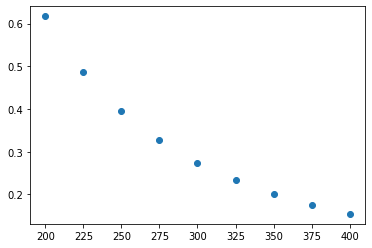

In [ ]:
plt.plot(distances,dose_rate_in_pSv, 'o')

# Referencias

https://docs.openmc.org/en/stable/usersguide/index.html

https://openmc.org/

https://github.com/openmc-dev/openmc-notebooks

https://github.com/fusion-energy/neutronics-workshop